# Imports

In [20]:
%matplotlib inline
import sys 
import os
import glob
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import random
import pickle
from pathlib import Path
from itertools import product

modpath = "../scripts"
sys.path.append(os.path.abspath(modpath))

from misc import pickler, open_table
import plot_utils

logging.basicConfig(filename='example.log', encoding='utf-8', level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [52]:
npg = plot_utils.npg_palette(); jco = plot_utils.jco_palette(); colors=plot_utils.matplotlib_init()
sns.set_style("whitegrid", {'axes.linewidth': 2, 'axes.edgecolor':'black'})

bbox=dict(boxstyle="round", fc="1",ec="0.8")

combined_td = pd.read_csv("../data/multi/combined_td.p1.csv", index_col=0) # Only post hoc fold change thresholds
combined_td2 = pd.read_csv("../data/multi/combined_td.p2.csv", index_col=0) # Formal fold change thresholds

combined_gsea_td = pd.read_csv(f"../data/multi/combined_gsea_td.csv", index_col=0)
dataorder = combined_td["Data"].drop_duplicates().values

datasetsfile = "../data/multi/datasets.txt"
with open(datasetsfile, "rb") as f:
    datasets = pickle.load(f)
    
DEAs = ["edgerlrt", "edger", "deseq2"]
outlier_methods = ["none","jk","pcah"]
all_N = [3,4,5,6,7,8,9,10,12,15]

# pretty names
prdea = {"edgerlrt":"edgeR LRT","edger":"edgeR QLF","deseq2":"DESeq2 Wald"}
prout = {"none":"None","jk":"Jackknife","pcah":"rPCA"}

sites = {"thyroid": "THCA",
         "lung": "LUAD",
         "kidney": "KIRC",
         "colorectal": "COAD",
         "breast": "BRCA",
         "liver": "LIHC",
         "prostate": "PRAD"}

if "KIRC_syn_hom" in datasets:
    del datasets["KIRC_syn_hom"]
    
ix = combined_td[combined_td["DEA"]=="DESeq2"].index
combined_td.loc[ix,"DEA"] = "DESeq2 Wald"
ix = combined_td2[combined_td2["DEA"]=="DESeq2"].index
combined_td2.loc[ix,"DEA"] = "DESeq2 Wald"

## Calculate expected metrics under the null model

In [54]:
from urn import random_jacc_rep,random_metrics

mean_genes = np.mean([datasets[d]["genes"] for d in datasets])

for i, c in enumerate([combined_td, combined_td2]):
    c["rnd_rep"] = random_jacc_rep(c["median_deg"]/mean_genes)
    
for dea in ["edger","edgerlrt","deseq2"]:
    deg_truth_lfc0 = np.mean([datasets[d]["truth_stats"][0][0.05][0][dea] for d in datasets])
    deg_truth_lfc0_post1 = np.mean([datasets[d]["truth_stats"][0][0.05][1][dea] for d in datasets])
    deg_truth_lfc1 = np.mean([datasets[d]["truth_stats"][1][0.05][1][dea] for d in datasets])
    
    for i, c in enumerate([combined_td, combined_td2]):
        deg_truth = deg_truth_lfc0 if i == 0 else deg_truth_lfc1
        cc = c[c["DEA"]==prdea[dea]]
        a=cc["median_deg"].apply(lambda x: random_metrics(x, mean_genes, deg_truth, w=1))
        ix = a.index
        c.loc[ix, "rnd_mcc"] = [aa[0][0] if isinstance(aa[0], np.ndarray) else np.nan for aa in a]
        c.loc[ix, "rnd_prec"] = [aa[1][0] if isinstance(aa[0], np.ndarray) else np.nan for aa in a]
        c.loc[ix, "rnd_rec"] = [aa[2][0] if isinstance(aa[0], np.ndarray) else np.nan for aa in a]
        
        # post hoc FC threshold
        if i == 0:
            cc = cc[cc["logFC"] == 1]
            deg_truth = deg_truth_lfc0_post1
            a=cc["median_deg"].apply(lambda x: random_metrics(x, mean_genes, deg_truth, w=1))
            ix = a.index
            c.loc[ix, "rnd_mcc"] = [aa[0][0] if isinstance(aa[0], np.ndarray) else np.nan for aa in a]
            c.loc[ix, "rnd_prec"] = [aa[1][0] if isinstance(aa[0], np.ndarray) else np.nan for aa in a]
            c.loc[ix, "rnd_rec"] = [aa[2][0] if isinstance(aa[0], np.ndarray) else np.nan for aa in a]

In [56]:
# combine results from post hoc and formal thresholds into one dataframe

a = combined_td2.copy()
a["logFC"] = "test"
combined_td3 = pd.concat([combined_td,a])
combined_td3 = combined_td3.reset_index(drop=True)
combined_td3.to_csv(f"../data/multi/combined_td_post_and_test.csv")

#gsea_truth = open_table(f"../data/multi/gsea_truth_df.csv")

In [57]:
combined_td3.head()

,Data,N,Out,DEA,FDR,logFC,median_deg,median_deg_adj,median_mcc,median_mcc_adj,...,median_prec_adj,median_rec,median_rec_adj,median_rep,median_rep_adj,id,rnd_rep,rnd_mcc,rnd_prec,rnd_rec
0,BRCA,3,Jackknife,DESeq2 Wald,0.001,0,718.5,876.0,0.128726,0.146167,...,0.953445,0.057651,0.072662,0.175170,0.197724,0,0.020317,-3.241152e-17,0.714934,0.039825
1,BRCA,3,Jackknife,DESeq2 Wald,0.001,1,718.5,876.0,0.344193,0.382647,...,0.918980,0.172963,0.219763,0.175170,0.197724,0,0.020317,2.794907e-17,0.190435,0.039825
2,BRCA,3,Jackknife,DESeq2 Wald,0.010,0,1249.0,1437.5,0.141576,0.154528,...,0.960558,0.093851,0.107236,0.215577,0.237113,0,0.035856,2.496810e-17,0.714934,0.069230
3,BRCA,3,Jackknife,DESeq2 Wald,0.010,1,1249.0,1437.5,0.420066,0.442052,...,0.862030,0.287053,0.329558,0.215577,0.238440,0,0.035856,1.435365e-16,0.190435,0.069230
4,BRCA,3,Jackknife,DESeq2 Wald,0.050,0,2084.5,2423.0,0.150321,0.164032,...,0.958754,0.145021,0.161678,0.245874,0.266746,0,0.061312,3.965317e-17,0.714934,0.115540


# Figure 1

- #DEGS vs N
- Replicability vs N

../figures/R_vs_N_None.pdf


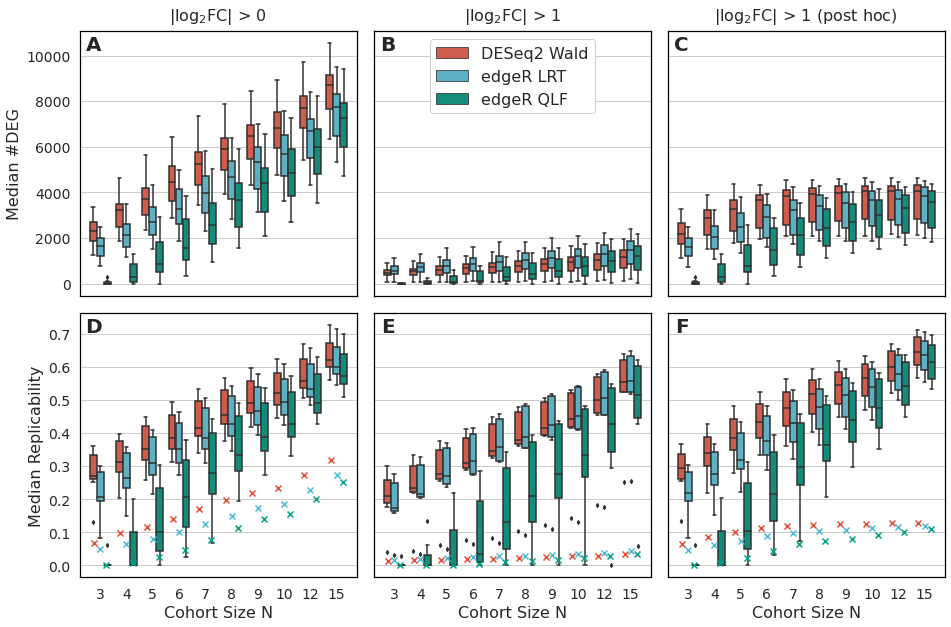

In [59]:
from urn import random_jacc_rep

fig, ax = plt.subplots(2,3,figsize=(13.5,9), sharex=True, sharey="row")
ax = ax.flatten()

outlier_method = "None"
FDR = 0.05
fs = 3 # fliersize

logFC = 0
comb_e = combined_td[(combined_td["Out"] == outlier_method) & (combined_td["logFC"] == logFC) & (combined_td["FDR"] == FDR)]
comb_e = comb_e.sort_values(by="DEA")
sns.boxplot(data=comb_e,x="N",y="median_rep",hue="DEA",ax=ax[3], palette=np.array(npg)[[0,1,2]], fliersize=fs)
sns.boxplot(data=comb_e,x="N",y="median_deg",hue="DEA",ax=ax[0], palette=np.array(npg)[[0,1,2]], fliersize=fs)

# TREAT
logFC = 1
comb_e = combined_td2[(combined_td2["Out"] == outlier_method) & (combined_td2["logFC"] == logFC) & (combined_td2["FDR"] == FDR)]
comb_e = comb_e.sort_values(by="DEA")
sns.boxplot(data=comb_e,x="N",y="median_rep",hue="DEA",ax=ax[4], palette=np.array(npg)[[0,1,2]], fliersize=fs)
sns.boxplot(data=comb_e,x="N",y="median_deg",hue="DEA",ax=ax[1], palette=np.array(npg)[[0,1,2]], fliersize=fs)

# POST HOC FC THRESHOLD
comb_e = combined_td[(combined_td["Out"] == outlier_method) & (combined_td["logFC"] == logFC) & (combined_td["FDR"] == FDR)]
comb_e = comb_e.sort_values(by="DEA")
sns.boxplot(data=comb_e,x="N",y="median_rep",hue="DEA",ax=ax[5], palette=np.array(npg)[[0,1,2]], fliersize=fs)
sns.boxplot(data=comb_e,x="N",y="median_deg",hue="DEA",ax=ax[2], palette=np.array(npg)[[0,1,2]], fliersize=fs)

for i, a in enumerate(ax) :
    a.legend([],[], frameon=False)
    a.set(xlabel=None, ylabel=None)
    a.annotate(chr(ord('A')+i), xy=(0.05, 0.95), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)
    
ax[0].set_ylabel("Median #DEG")
ax[3].set_ylabel("Median Replicability")
for a in ax[3:]: a.set_xlabel("Cohort Size N")

ax[0].set_title(r"|log$_2$FC| > 0", fontsize=16, pad=11)
ax[1].set_title(r"|log$_2$FC| > 1", fontsize=16, pad=11)
ax[2].set_title(r"|log$_2$FC| > 1 (post hoc)", fontsize=16, pad=11)

handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles, labels, loc='upper center',framealpha=1)

# plot expected rep from random genes
N = np.mean([datasets[s]["genes"] for s in datasets])
combined_td["rnd_rep"] = random_jacc_rep(combined_td["median_deg"]/N)
combined_td2["rnd_rep"] = random_jacc_rep(combined_td2["median_deg"]/N)


for logFC in [0,1,"post"]:
    a = ax[3] if logFC == 0 else ax[4]
    if logFC == "post":
        logFC = 1
        a = ax[5]
        
    c = combined_td2 if a == ax[4] else combined_td
    comb_e = c[(c["Out"] == outlier_method) & (c["logFC"] == logFC) & (c["FDR"] == FDR)]
    for k, N in enumerate(set(combined_td["N"])):
        for dea in set(combined_td["DEA"]):
            comb_ee = comb_e[(comb_e["N"]==N)&(comb_e["DEA"]==dea)]
            rnd_rep = comb_ee["rnd_rep"].median()
            if dea == "edgeR QLF": x, col = k+0.23, npg[2]
            elif dea == "DESeq2 Wald": x, col = k-0.23, npg[0]
            else: x, col = k, npg[1]
            a.scatter(x,rnd_rep,marker="x",color=col,zorder=99)
            
figpath = f"../figures/R_vs_N_{outlier_method}.pdf"
fig.tight_layout()
fig.savefig(figpath)
print(figpath)

# Figure 2

- Precision vs N
- Precision vs FDR

In [60]:
FDRs = [1e-4,0.001,0.01,0.05,0.1,0.2,0.5]
cancers = [d for d in datasets]
cohorts = 100
lfcs = [0,1,"post"]
overwrite = False

def make_prec_df():
    vals = ["Precision","#DEGs","Precision_Mean","#DEGs_Mean"]
    iterables = [cancers,all_N,["none"],DEAs,FDRs,[0,1,"post"],vals]
    multi_cols = pd.MultiIndex.from_product(iterables, names=["Data", "N", "Out", "DEA", "FDR", "logFC","Val"])
    prec_df = pd.DataFrame(columns=multi_cols)

    all_fdr_dict = {fdr:{lfc: {"truth":None,"precs":[],"n_degs":[]} for lfc in lfcs} for fdr in FDRs}

    for site in sites:

        data = sites[site]
        for lfc in lfcs:
            param_set = "p2" if lfc == 1 else "p1"
            lfc_suffix = 0 if lfc == "post" else lfc
            for dea in DEAs:
                f = f"../data/{site}/{data}/{data}.{dea}.lfc{lfc_suffix}"
                truth_tool = open_table(f)
                

                for fdr in FDRs:
                    precs,n_degs = [],[]
                    truth_tool_fdr = truth_tool[truth_tool["FDR"]<fdr]
                    if lfc == "post":
                        truth_tool_fdr = truth_tool_fdr[truth_tool_fdr["logFC"].abs()>1]
                    all_fdr_dict[fdr][lfc]["truth"] = truth_tool_fdr


                for out in ["none"]:# outlier_methods:
                    print(site,dea,out,lfc)

                    for i,N in enumerate(all_N):


                        for fdr in FDRs:
                            all_fdr_dict[fdr][lfc]["precs"], all_fdr_dict[fdr][lfc]["n_degs"] = [], []

                        for cohort in range(1,cohorts+1):
                            cf = f"../data/{site}/{data}/{data}_N{N}/{data}_N{N}_{cohort:04}/tab.{out}.{dea}.{param_set}"
                            ct = open_table(cf)

                            for fdr in FDRs:
                                degs = ct[ct["FDR"]<fdr]
                                truth_tool_fdr = all_fdr_dict[fdr][lfc]["truth"]
                                if lfc == "post":
                                    degs = degs[degs["logFC"].abs()>1]
                                TP_tool = degs.index.intersection(truth_tool_fdr.index)
                                prec_tool = len(TP_tool)/len(degs) if len(degs) > 0 else np.nan
                                all_fdr_dict[fdr][lfc]["precs"].append(prec_tool)
                                all_fdr_dict[fdr][lfc]["n_degs"].append(len(degs))

                        for fdr in FDRs:
                            prec_df.loc[0,(data,N,out,dea,fdr,lfc,"Precision")] = np.nanmedian(all_fdr_dict[fdr][lfc]["precs"])
                            prec_df.loc[0,(data,N,out,dea,fdr,lfc,"#DEGs")] = np.nanmedian(all_fdr_dict[fdr][lfc]["n_degs"])
                            prec_df.loc[0,(data,N,out,dea,fdr,lfc,"Precision_Mean")] = np.nanmean(all_fdr_dict[fdr][lfc]["precs"])
                            prec_df.loc[0,(data,N,out,dea,fdr,lfc,"#DEGs_Mean")] = np.nanmean(all_fdr_dict[fdr][lfc]["n_degs"])
    return prec_df

if overwrite:
    prec_df = make_prec_df()
    prec_df = prec_df.unstack().unstack(level="Val").reset_index(level=["Data", "N", "Out", "DEA", "FDR", "logFC"], drop=False)
    prec_df.reset_index(drop=True, inplace=True)

    for clean in prout:
        prec_df.loc[(prec_df[prec_df["Out"] == clean]).index, "Out"] = prout[clean]
    for clean in prdea:
        prec_df.loc[(prec_df[prec_df["DEA"] == clean]).index, "DEA"] = prdea[clean]
    prec_df.to_csv(f"../data/multi/prec_df_nan.csv")
    
else:
    prec_df = pd.read_csv(f"../data/multi/prec_df_nan.csv", index_col=0)

ix = prec_df[prec_df["DEA"]=="DESeq2"].index
prec_df.loc[ix,"DEA"] = "DESeq2 Wald"
prec_df.head()

,Data,N,Out,DEA,FDR,logFC,#DEGs,#DEGs_Mean,Precision,Precision_Mean
0,BRCA,3,None,DESeq2 Wald,0.0001,0,420.5,546.78,0.975146,0.966127
1,BRCA,3,None,DESeq2 Wald,0.0001,1,95.0,159.08,0.922355,0.919643
2,BRCA,3,None,DESeq2 Wald,0.0001,post,420.5,546.78,0.949559,0.937423
3,BRCA,3,None,DESeq2 Wald,0.0010,0,694.5,829.40,0.970965,0.963440
4,BRCA,3,None,DESeq2 Wald,0.0010,1,159.5,233.66,0.921311,0.912888


0.6970068889064851
0.11212289175706713
0.1895478660226463
../figures/precision_vs_n_fdr.pdf


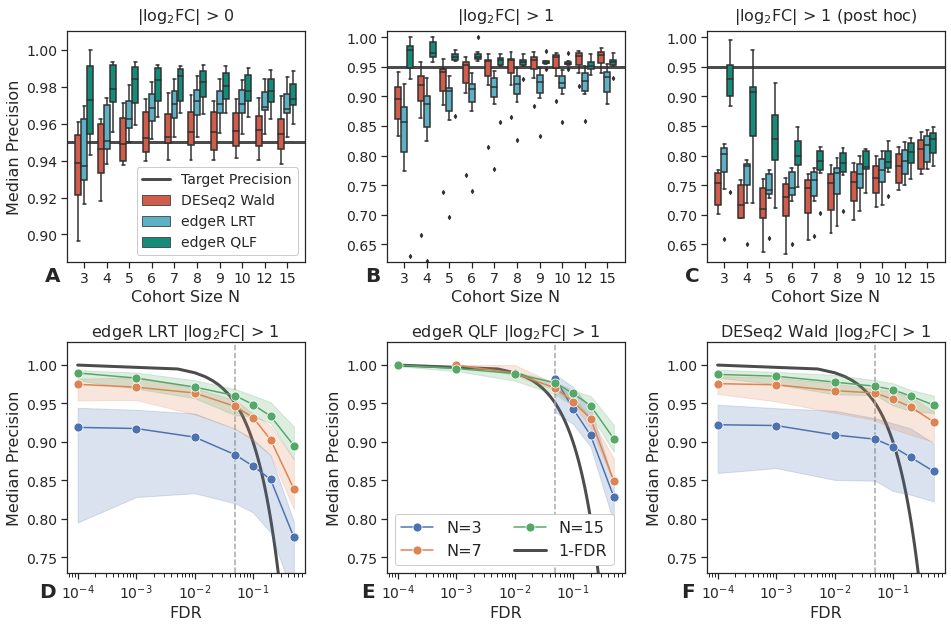

In [61]:
sns.set_style("ticks")
fig, ax = plt.subplots(2,3,figsize=(13.5,9), sharex=False, sharey=False)
ax = ax.flatten()

outlier_method = "None"
FDR = 0.05
palette = np.array(npg)[[0,1,2]]
z = 2
fs = 3

#### PRECISION VS. N ####

# No fold change threshold
logFC = 0
comb_e = combined_td3[(combined_td3["Out"] == outlier_method) & (combined_td3["logFC"] == logFC) & (combined_td3["FDR"] == FDR)]
comb_e = comb_e.sort_values(by="DEA")
sns.boxplot(data=comb_e,x="N",y="median_prec",hue="DEA",ax=ax[0], palette=palette, zorder=z, whiskerprops={"zorder":z}, boxprops={"zorder":z},  fliersize=fs)

# TREAT
logFC = "test"
comb_e = combined_td3[(combined_td3["Out"] == outlier_method) & (combined_td3["logFC"] == logFC) & (combined_td3["FDR"] == FDR)]
comb_e = comb_e.sort_values(by="DEA")
sns.boxplot(data=comb_e,x="N",y="median_prec",hue="DEA",ax=ax[1], palette=palette, zorder=z, whiskerprops={"zorder":z}, boxprops={"zorder":z},  fliersize=fs)
#prad = comb_e[comb_e["Data"]=="PRAD"]
#display(prad.sort_values(by="median_prec").head()[comb_e.columns[:-5]])

# POST HOC FC THRESHOLD
logFC = 1
comb_e = combined_td3[(combined_td3["Out"] == outlier_method) & (combined_td3["logFC"] == logFC) & (combined_td3["FDR"] == FDR)]
comb_e = comb_e.sort_values(by="DEA")
sns.boxplot(data=comb_e,x="N",y="median_prec",hue="DEA",ax=ax[2], palette=palette, zorder=z, whiskerprops={"zorder":z}, boxprops={"zorder":z},  fliersize=fs)

# plot expected metrics from random genes

for i, logFC in enumerate([0,"test",1]):

    met = "rnd_prec"
    comb_e = combined_td3[(combined_td3["Out"] == outlier_method) & (combined_td3["logFC"] == logFC) & (combined_td3["FDR"] == FDR)]
    
    a = ax[i]
    null_precision = comb_e[met].median()
    print(null_precision)
    a.scatter(0,null_precision,color="black", alpha=0.8, zorder=0,marker="x") #label=f"Null Precision: {null_precision:.2f}"
    
    for k, N in enumerate(set(combined_td["N"])):
        for dea in set(combined_td["DEA"]):
            comb_ee = comb_e[(comb_e["N"]==N)&(comb_e["DEA"]==dea)]
            rnd = comb_ee[met].median()
            if dea == "edgeR QLF": x, c = k+0.23, npg[2]
            elif dea == "DESeq2": x, c = k-0.23, npg[0]
            else: x, c = k, npg[1]
            a.scatter(x,rnd,marker="x",color=c,zorder=99)
            
ax[0].set_title(r"|log$_2$FC| > 0", fontsize=16, pad=11)
ax[1].set_title(r"|log$_2$FC| > 1", fontsize=16, pad=11)
ax[2].set_title(r"|log$_2$FC| > 1 (post hoc)", fontsize=16, pad=11)
            
for i, a in enumerate(ax[:3]):
    a.legend([],[], frameon=False)
    a.set(xlabel="Cohort Size N", ylabel=None)
    a.axhline(0.95, ls="-",color="black", alpha=0.7,label="Target Precision",lw=3, zorder=1)
    a.annotate(chr(ord('A')+i), xy=(-0.06, -0.06), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)

ax[0].set_ylabel("Median Precision")

ax[0].set_ylim(0.885,1.01)
ax[1].set_ylim(0.62,1.01)
ax[2].set_ylim(0.62,1.01)

for a in ax[:1]:
    handles, labels = a.get_legend_handles_labels()
    #handles, labels = [handles[0],handles[-1]], [labels[0],labels[-1]]
    loc = "lower right" if a != ax[2] else "upper right"
    a.legend(handles, labels, loc=loc, framealpha=1, fontsize=14)
    
    
#### PRECISION VS. FDR ####
lfc = "1"
FDRs = [1e-4,0.001,0.01,0.05,0.1,0.2,0.5]
cancers = [d for d in datasets if "syn" not in d]

def rm_nan_prec(prec_df):
    """Remove FDRs where precision could not be determined"""
    c=prec_df.groupby("FDR")
    for cc in c:
        if cc[1]["Precision"].isna().sum() > 0:
            prec_df = prec_df[prec_df["FDR"]!=cc[0]]
    return prec_df

for i,dea in enumerate(prdea):
    i+=3
    dea = prdea[dea]
    
    a = prec_df[(prec_df["DEA"]==dea)&(prec_df["N"]==3)&(prec_df["logFC"]==lfc)]
    c=a.groupby("FDR")
    for cc in c:
        if cc[1]["Precision"].isna().sum() > 0:
            a = a[a["FDR"]!=cc[0]]
            
    if (len(a)>0): sns.lineplot(data=a,x="FDR",y="Precision",ax=ax[i], color=sns.color_palette()[0], marker="o",ms=9,label="N=3",estimator=np.median)
    else: sns.lineplot(x=[-1],y=[-1],ax=ax[i], color=sns.color_palette()[0], marker="o",ms=9,label="N=3",estimator=np.median) # dummy for legend
    
    a = prec_df[(prec_df["DEA"]==dea)&(prec_df["N"]==7)&(prec_df["logFC"]==lfc)]
    c=a.groupby("FDR")
    for cc in c:
        if cc[1]["Precision"].isna().sum() > 0:
            a = a[a["FDR"]!=cc[0]]
            
    if (len(a)>0): sns.lineplot(data=a,x="FDR",y="Precision",ax=ax[i], color=sns.color_palette()[1], marker="o",ms=9,label="N=7",estimator=np.median)
    else: sns.lineplot(x=[-1],y=[-1],ax=ax[i], color=sns.color_palette()[1], marker="o",ms=9,label="N=7",estimator=np.median) # dummy for legend
    
    a = prec_df[(prec_df["DEA"]==dea)&(prec_df["N"]==15)&(prec_df["logFC"]==lfc)]
    a = rm_nan_prec(a)
            
    if (len(a)>0): sns.lineplot(data=a,x="FDR",y="Precision",ax=ax[i], color=sns.color_palette()[2], marker="o",ms=9,label="N=15",estimator=np.median)
    else: sns.lineplot(x=[-1],y=[-1],ax=ax[i], color=sns.color_palette()[2], marker="o",ms=9,label="N=15",estimator=np.median) # dummy for legend
    
    ax[i].set(xscale="log",ylabel="Median Precision",ylim=(0.73,1.03))
    x = np.linspace(min(FDRs),max(FDRs),100)
    ax[i].plot(x,1-x,color="black",lw=3, alpha=0.7,label="1-FDR",zorder=0)
    
    if i == 4: ax[i].legend(framealpha=1,ncol=2)
    else: ax[i].legend([],[], frameon=False)
    ax[i].set_title(rf"{dea} |log$_2$FC| > 1", fontsize=16)
    
    ax[i].axvline(0.05,ls="--",c="darkgrey",zorder=0)
    
for i, aa in enumerate(ax[3:]) :
    aa.annotate(chr(ord('A')+i+3), xy=(-0.08, -0.08), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)

figpath = f"../figures/precision_vs_n_fdr.pdf"
fig.tight_layout()
fig.savefig(figpath)
print(figpath)

# Figure 3

- MCC vs N
- Recall vs N

../figures/mcc_recall_vs_N_None.pdf


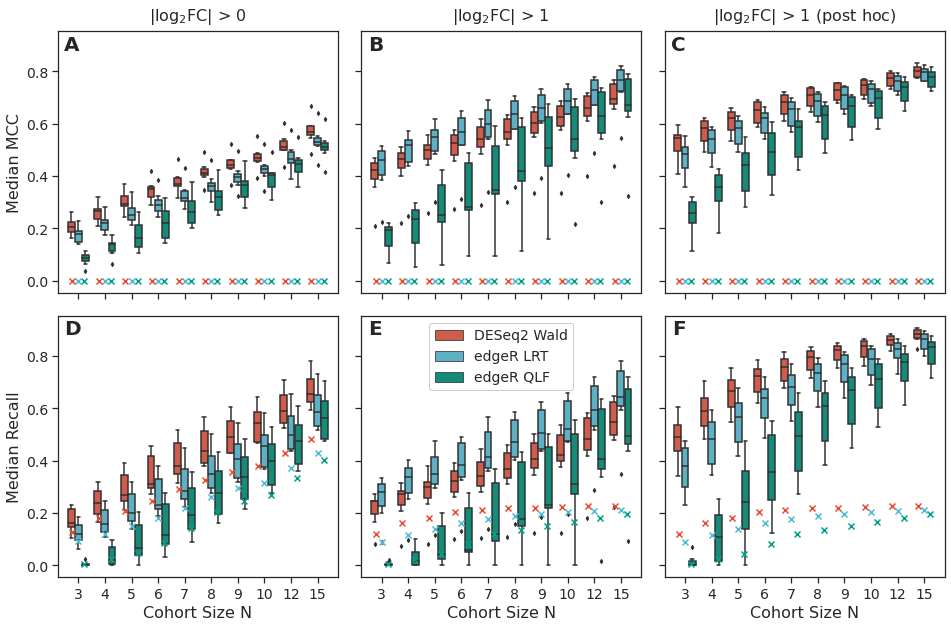

In [63]:
fig, ax = plt.subplots(2,3,figsize=(13.5,9), sharex=True, sharey=True)
ax = ax.flatten()

outlier_method = "None"
FDR = 0.05
palette = np.array(npg)[[0,1,2]]
z = 2
fs = 3

logFC = 0
comb_e = combined_td[(combined_td["Out"] == outlier_method) & (combined_td["logFC"] == logFC) & (combined_td["FDR"] == FDR)]
comb_e = comb_e.sort_values(by="DEA")
sns.boxplot(data=comb_e,x="N",y="median_mcc",hue="DEA",ax=ax[0], palette=palette, zorder=z, whiskerprops={"zorder":z}, boxprops={"zorder":z},  fliersize=fs)
sns.boxplot(data=comb_e,x="N",y="median_rec",hue="DEA",ax=ax[3], palette=palette, zorder=z, whiskerprops={"zorder":z}, boxprops={"zorder":z},  fliersize=fs)

# TREAT
logFC = 1
comb_e = combined_td2[(combined_td2["Out"] == outlier_method) & (combined_td2["logFC"] == logFC) & (combined_td2["FDR"] == FDR)]
comb_e = comb_e.sort_values(by="DEA")

sns.boxplot(data=comb_e,x="N",y="median_mcc",hue="DEA",ax=ax[1], palette=palette, zorder=z, whiskerprops={"zorder":z}, boxprops={"zorder":z},  fliersize=fs)
sns.boxplot(data=comb_e,x="N",y="median_rec",hue="DEA",ax=ax[4], palette=palette, zorder=z, whiskerprops={"zorder":z}, boxprops={"zorder":z},  fliersize=fs)

# POST HOC FC THRESHOLD
comb_e = combined_td[(combined_td["Out"] == outlier_method) & (combined_td["logFC"] == logFC) & (combined_td["FDR"] == FDR)]
comb_e = comb_e.sort_values(by="DEA")
sns.boxplot(data=comb_e,x="N",y="median_mcc",hue="DEA",ax=ax[2], palette=palette, zorder=z, whiskerprops={"zorder":z}, boxprops={"zorder":z},  fliersize=fs)
sns.boxplot(data=comb_e,x="N",y="median_rec",hue="DEA",ax=ax[5], palette=palette, zorder=z, whiskerprops={"zorder":z}, boxprops={"zorder":z},  fliersize=fs)

# # plot expected metrics from random genes

for i, logFC in enumerate([0,1,"post"]):
    for j, met in enumerate(["rnd_mcc","rnd_rec"]):
        
        if logFC == "post":
            logFC =1
            a = ax[2] if j == 0 else ax[5]
        else:
            a = ax[i] if j == 0 else ax[i+3]

        c = combined_td3
        comb_e = c[(c["Out"] == outlier_method) & (c["logFC"] == logFC) & (c["FDR"] == FDR)]

        for k, N in enumerate(set(combined_td3["N"])):
            for dea in set(combined_td3["DEA"]):
                comb_ee = comb_e[(comb_e["N"]==N)&(comb_e["DEA"]==dea)]
                rnd = comb_ee[met].median()
                if dea == "edgeR QLF": x, c = k+0.23, npg[2]
                elif dea == "DESeq2 Wald": x, c = k-0.23, npg[0]
                else: x, c = k, npg[1]
                a.scatter(x,rnd,marker="x",color=c,zorder=99)
            
for i, a in enumerate(ax):
    a.legend([],[], frameon=False)
    a.set(xlabel="Cohort Size N" if i > 2 else "", ylabel=None)
    a.annotate(chr(ord('A')+i), xy=(0.05, 0.95), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)

handles, labels = ax[4].get_legend_handles_labels()
ax[4].legend(handles, labels, loc='upper center',framealpha=1, fontsize=14)
    
ax[0].set_title(r"|log$_2$FC| > 0", fontsize=16, pad=11)
ax[1].set_title(r"|log$_2$FC| > 1", fontsize=16, pad=11)
ax[2].set_title(r"|log$_2$FC| > 1 (post hoc)", fontsize=16, pad=11)

for a in ax[7:]: a.set(xlabel="Cohort Size (N)")
ax[3].set_ylabel("Median Recall")
ax[0].set_ylabel("Median MCC")

figpath = f"../figures/mcc_recall_vs_N_{outlier_method}.pdf"
fig.tight_layout()
fig.savefig(figpath)
print(figpath)

# Figures 4, A5-A8

Enrichment metrics vs N

In [ ]:
combined_gsea_td["DEA_Enrichment"] = combined_gsea_td["DEA"] + "_" + combined_gsea_td["Enrichment"]

for d in datasets:
    print(d)
    for out in ["None"]:
        for dea in DEAs:
            dea = prdea[dea]
            for enrichment in set(gsea_truth["Enrichment"]):
                for lib in set(gsea_truth["Library"]):
                    for fdr in [0.05]:
                        g=gsea_truth[(gsea_truth["Data"]==d)&(gsea_truth["Out"]==out)&(gsea_truth["DEA"]==dea)&(gsea_truth["Enrichment"]==enrichment)&(gsea_truth["Library"]==lib)]
                        c=combined_gsea_td[(combined_gsea_td["Data"]==d)&(combined_gsea_td["Out"]==out)&(combined_gsea_td["DEA"]==dea)&(combined_gsea_td["Enrichment"]==enrichment)&(combined_gsea_td["Library"]==lib)].index
                        try:
                            combined_gsea_td.loc[c,"truth"] = g["truth"].values[0]
                            combined_gsea_td.loc[c,"truth_common"] = g["truth_common"].values[0]
                        except IndexError:

                            combined_gsea_td.loc[c,"truth"] = np.nan
                            combined_gsea_td.loc[c,"truth_common"] = np.nan                    
comb = combined_gsea_td.dropna()